### Download Data

In [1]:
import os
import requests
from tqdm import tqdm

# Define the base URL and file names
base_url = "https://github.com/zalandoresearch/fashion-mnist/raw/master/data/fashion/"
files = [
    "train-images-idx3-ubyte.gz",
    "train-labels-idx1-ubyte.gz",
    "t10k-images-idx3-ubyte.gz",
    "t10k-labels-idx1-ubyte.gz",
]

# Ensure the /data/ directory exists
data_dir = "data"
os.makedirs(data_dir, exist_ok=True)

# Download each file
for file_name in files:
    url = base_url + file_name
    file_path = os.path.join(data_dir, file_name)

    if not os.path.exists(file_path):
        print(f"Downloading {file_name}...")
        with requests.get(url, stream=True) as response:
            response.raise_for_status()
            with open(file_path, "wb") as f:
                for chunk in tqdm(response.iter_content(chunk_size=8192)):
                    f.write(chunk)
        print(f"Saved to {file_path}")
    else:
        print(f"{file_name} already exists. Skipping download.")


3226it [00:00, 5641.70it/s]


Saved to data/train-images-idx3-ubyte.gz


4it [00:00, 186.34it/s]


Saved to data/train-labels-idx1-ubyte.gz


540it [00:00, 776.22it/s]


Saved to data/t10k-images-idx3-ubyte.gz


1it [00:00, 581.09it/s]

Saved to data/t10k-labels-idx1-ubyte.gz


### PyTorch Implementation

In [10]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, random_split
from torch.optim.lr_scheduler import ReduceLROnPlateau
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.tensorboard import SummaryWriter

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Hyperparameters
batch_size = 64
learning_rate = 0.001
epochs = 20

# Load and preprocess FashionMNIST dataset
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

train_dataset = datasets.FashionMNIST(root='./data', train=True, transform=transform, download=True)
test_dataset = datasets.FashionMNIST(root='./data', train=False, transform=transform, download=True)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Define the base LeNet-5 architecture
# class LeNet5(nn.Module):
#     def __init__(self, dropout_rate=0, l2_reg=0, batch_norm=False):
#         super(LeNet5, self).__init__()
#         self.conv1 = nn.Conv2d(1, 6, kernel_size=5)
#         self.conv2 = nn.Conv2d(6, 16, kernel_size=5)
#         self.batch_norm1 = nn.BatchNorm2d(6) if batch_norm else nn.Identity()
#         self.batch_norm2 = nn.BatchNorm2d(16) if batch_norm else nn.Identity()
#         self.fc1 = nn.Linear(16 * 4 * 4, 120)
#         self.dropout = nn.Dropout(dropout_rate)
#         self.fc2 = nn.Linear(120, 84)
#         self.fc3 = nn.Linear(84, 10)

#     def forward(self, x):
#         x = torch.relu(self.conv1(x))
#         x = self.batch_norm1(x)
#         x = torch.avg_pool2d(x, 2)
#         x = torch.relu(self.conv2(x))
#         x = self.batch_norm2(x)
#         x = torch.avg_pool2d(x, 2)
#         x = x.view(-1, 16 * 4 * 4)
#         x = torch.relu(self.fc1(x))
#         x = self.dropout(x)
#         x = torch.relu(self.fc2(x))
#         x = self.fc3(x)
#         return x

class LeNet5(nn.Module):
    def __init__(self, use_batch_norm=False, use_dropout=False, dropout_prob=0.5):
        super(LeNet5, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, kernel_size=[5, 5])
        self.avg_pool1 = nn.AvgPool2d(kernel_size=[2, 2], stride=2)
        self.conv2 = nn.Conv2d(6, 16, kernel_size=[5, 5])
        self.avg_pool2 = nn.AvgPool2d(kernel_size=[2, 2], stride=2)
        self.conv3 = nn.Conv2d(16, 120, kernel_size=[5, 5])
        self.fc1 = nn.Linear(120, 84)
        self.fc2 = nn.Linear(84, 10)
        self.use_batch_norm = use_batch_norm
        self.use_dropout = use_dropout
        if use_batch_norm:
            self.batch_norm1 = nn.BatchNorm2d(6)
            self.batch_norm2 = nn.BatchNorm2d(16)
            self.batch_norm3 = nn.BatchNorm2d(120)
        if use_dropout:
            self.dropout = nn.Dropout(dropout_prob)

    def forward(self, x):
        x = self.conv1(x)
        if self.use_batch_norm:
            x = self.batch_norm1(x)
        x = F.relu(x)
        x = self.avg_pool1(x)

        x = self.conv2(x)
        if self.use_batch_norm:
            x = self.batch_norm2(x)
        x = F.relu(x)
        x = self.avg_pool2(x)

        x = self.conv3(x)
        if self.use_batch_norm:
            x = self.batch_norm3(x)
        x = F.relu(x)

        x = torch.flatten(x, 1)
        if self.use_dropout:
            x = self.dropout(x)
        x = F.relu(self.fc1(x))

        x = F.softmax(self.fc2(x), dim=1)
        return x

# Train and evaluate the model
def train_and_evaluate(model, optimizer, criterion, train_loader, test_loader):
    train_accs, test_accs = [], []

    for epoch in range(epochs):
        model.train()
        correct, total = 0, 0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        train_accs.append(correct / total)

        # Evaluate on test data
        model.eval()
        correct, total = 0, 0
        with torch.no_grad():
            for images, labels in test_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        test_accs.append(correct / total)

    return train_accs, test_accs

# Plot convergence graphs
def plot_convergence(train_acc, test_acc, title):
    plt.plot(train_acc, label="Train Accuracy")
    plt.plot(test_acc, label="Test Accuracy")
    plt.title(title)
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.grid()
    plt.show()

def plot_convergence(train_acc, test_acc, title):
    # Plot train and test accuracies
    plt.plot(train_acc, label="Train Accuracy")
    plt.plot(test_acc, label="Test Accuracy")
    
    # Find the epoch where the highest test accuracy occurred
    best_epoch = test_acc.index(max(test_acc))
    
    # Add a vertical line at the highest accuracy point
    plt.axvline(x=best_epoch, color='r', linestyle='--', label=f'Best Accuracy at Epoch {best_epoch+1}')
    
    # Add title, labels, and legend
    plt.title(title)
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend()
    
    # Add a grid for better readability
    plt.grid()

    # Display the plot
    plt.show()

# Main experiment
criterion = nn.CrossEntropyLoss()

# Without Regularization
model = LeNet5().to(device)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
train_acc, test_acc = train_and_evaluate(model, optimizer, criterion, train_loader, test_loader)
plot_convergence(train_acc, test_acc, "No Regularization")

# With Dropout
model_dropout = LeNet5(dropout_rate=0.5).to(device)
optimizer_dropout = optim.Adam(model_dropout.parameters(), lr=learning_rate)
train_acc_dropout, test_acc_dropout = train_and_evaluate(model_dropout, optimizer_dropout, criterion, train_loader, test_loader)
plot_convergence(train_acc_dropout, test_acc_dropout, "Dropout Regularization")

# With Weight Decay (L2 Regularization)
model_l2 = LeNet5().to(device)
optimizer_l2 = optim.Adam(model_l2.parameters(), lr=learning_rate, weight_decay=0.001)
train_acc_l2, test_acc_l2 = train_and_evaluate(model_l2, optimizer_l2, criterion, train_loader, test_loader)
plot_convergence(train_acc_l2, test_acc_l2, "Weight Decay Regularization")

# With Batch Normalization
model_bn = LeNet5(batch_norm=True).to(device)
optimizer_bn = optim.Adam(model_bn.parameters(), lr=learning_rate)
train_acc_bn, test_acc_bn = train_and_evaluate(model_bn, optimizer_bn, criterion, train_loader, test_loader)
plot_convergence(train_acc_bn, test_acc_bn, "Batch Normalization Regularization")

ModuleNotFoundError: No module named 'tensorboard'

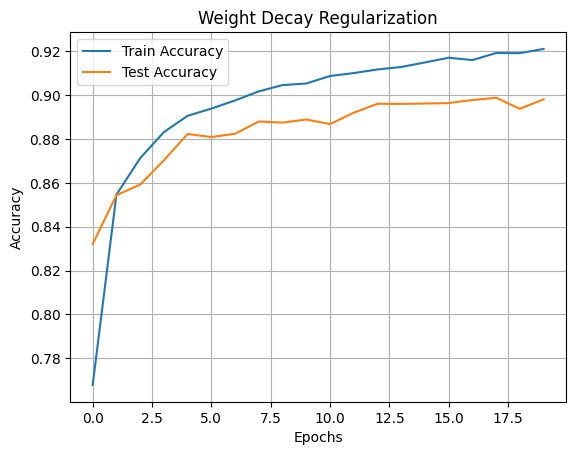

In [7]:
# With Weight Decay (L2 Regularization)
model_l2 = LeNet5().to(device)
optimizer_l2 = optim.Adam(model_l2.parameters(), lr=learning_rate, weight_decay=0.001)
train_acc_l2, test_acc_l2 = train_and_evaluate(model_l2, optimizer_l2, criterion, train_loader, test_loader)
plot_convergence(train_acc_l2, test_acc_l2, "Weight Decay Regularization")

In [8]:
import pandas as pd

# Example final accuracies (replace with your actual results)
results = {
    "Technique": [
        "No Regularization",
        "Dropout",
        "Weight Decay (L2)",
        "Batch Normalization"
    ],
    "Train Accuracy (%)": [
        train_acc[-1] * 100,
        train_acc_dropout[-1] * 100,
        train_acc_l2[-1] * 100,
        train_acc_bn[-1] * 100
    ],
    "Test Accuracy (%)": [
        test_acc[-1] * 100,
        test_acc_dropout[-1] * 100,
        test_acc_l2[-1] * 100,
        test_acc_bn[-1] * 100
    ],
}

# Create DataFrame
df_results = pd.DataFrame(results)

# Display DataFrame
display(df_results)

# Optionally save to a CSV file
df_results.to_csv("lenet5_results.csv", index=False)

,Technique,Train Accuracy (%),Test Accuracy (%)
0,No Regularization,94.233333,89.96
1,Dropout,90.231667,88.64
2,Weight Decay (L2),92.110000,89.81
3,Batch Normalization,96.645000,88.57
